## Zillow Regression Project

### Project Goals:

- Construct a machine learning regression model that improves predicted property tax assessed values of single family homes in Ventura, Orange, and Los Angeles counties.
- Find the key drivers of property value for single family properties.
- Forecast tax assessed home value with enhanced accuracy.
- Empower zillow executives to improve the current predictions using my recommendations.
- Thoroughly document the process and key findings.

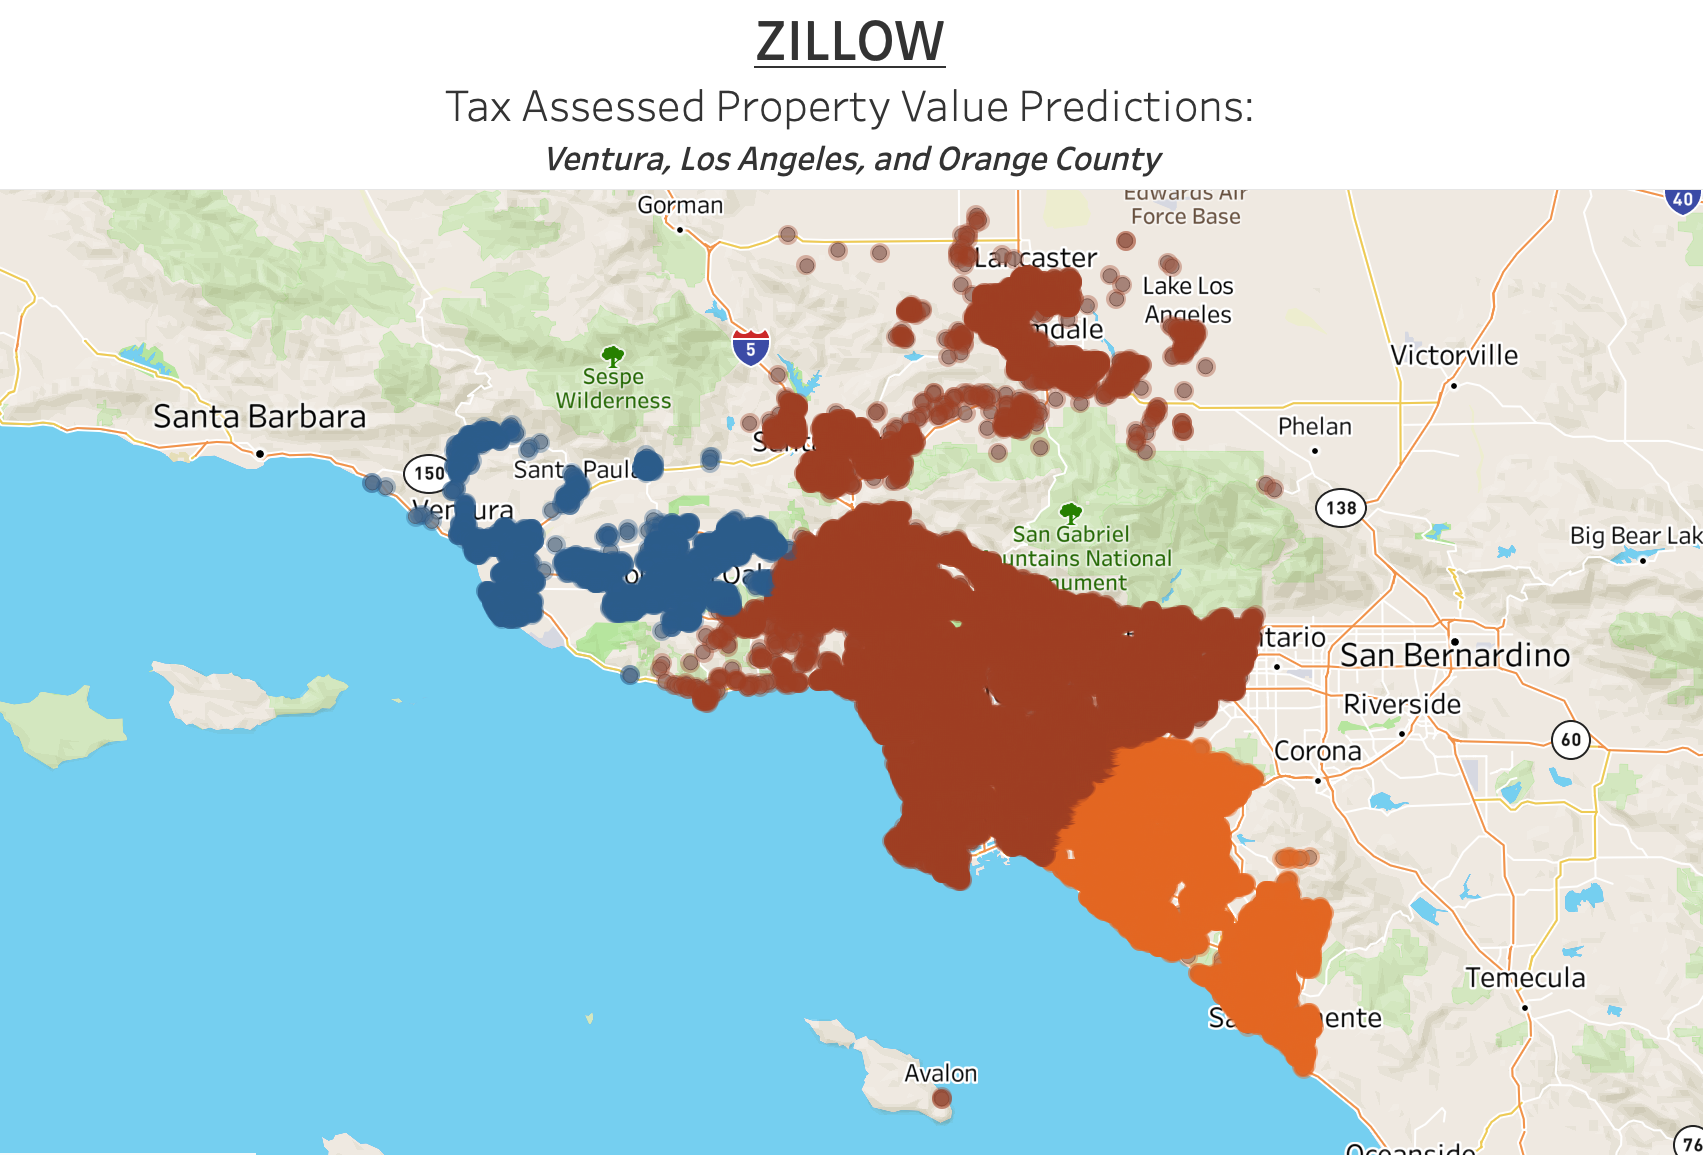

### Summary of Findings & Recommendations:
- My analysis indicates that the top drivers of tax assessed home values are:
     > - property size (square footage)
     > - property's year built
     > - bedroom count
     > - bathroom count

- I built and trained a Polynomial Regression model which is able to improve predicted tax assessed home values by ~ $80,000 (22% improved from baseline/previous predictions).
 
- By utilizing this model with the top drivers of tax assessed home values , I can recommend employing this new model with reasonable confidence.

### Data Acquisition & Preparation
- Import necessary libraries
- Import user defined functions (acquire.py, wrangle.py)
- Data imported meets the following conditions:
    > - Single family homes in Orange county, CA, Ventura, CA, or Los Angeles, CA
    > - Had a transaction in 2017
    > - Data available in zillow properties_2017 table

In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import wrangle
import prepare

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

In [2]:
df = acquire.get_zillow_data()
# this is a user-defined function in acquire.py that pulls in selected data from the SQL database

In [3]:
df.info()
# gives an overview of the imported data including number of records, column names, number of non-null records, and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    52441 non-null  int64  
 1   parcelid                      52441 non-null  int64  
 2   taxvaluedollarcnt             52440 non-null  float64
 3   bedroomcnt                    52441 non-null  float64
 4   bathroomcnt                   52441 non-null  float64
 5   yearbuilt                     52325 non-null  float64
 6   fips                          52441 non-null  float64
 7   calculatedfinishedsquarefeet  52359 non-null  float64
 8   lotsizesquarefeet             52072 non-null  float64
 9   latitude                      52441 non-null  float64
 10  longitude                     52441 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.4 MB


### Acquired data includes:

   > - parcelid: property identifier
    > - bedroomcnt: bedroom count of property
    > - bathroomcnt: bathroom count of property
    > - yearbuilt: property's year built
    > - fips: county of property
    > - calculatedfinishedsquarefeet: square footage of property
    > - lotsizesquarefeet: square footage of property's lot/land
    > - latitude: latitude coordinate of property
    > - longitude: longitude coordinate of property


### Handling Null (missing) Values:

In [4]:
df.isna().sum()
# shows the number of null values in each column in the dataframe

Unnamed: 0                        0
parcelid                          0
taxvaluedollarcnt                 1
bedroomcnt                        0
bathroomcnt                       0
yearbuilt                       116
fips                              0
calculatedfinishedsquarefeet     82
lotsizesquarefeet               369
latitude                          0
longitude                         0
dtype: int64

In [5]:
def printmd(string): # function to format text style
    display(Markdown(string))
printmd('***Number of records with nulls in all 3 columns:*** {:,} records'
     .format(df['calculatedfinishedsquarefeet'].isna().sum()  & df['yearbuilt'].isna().sum() & df['lotsizesquarefeet'].isna().sum()))
# shows how many records with nulls have null values in all 3 columns where nulls are present
printmd('***Percentage of nulls in the entire dataframe:*** {:,.2%} of records'
     .format(df.isna().sum().sum() / len(df)))
# shows how many records with nulls have null values in all 3 columns where nulls are present

***Number of records with nulls in all 3 columns:*** 80 records

***Percentage of nulls in the entire dataframe:*** 1.08% of records

### Decision to drop null values:

Because the dataframe only has 1% of records with null values, dropping these records in the data preparation stage will not impact data integrity.

In [6]:
df = wrangle.wrangle_zillow(df)
# this pre-defined user function cleans and prepares as well as reducing the number of outliers in features.

df = wrangle.wrangle_locs(df)
# this pre-defined user function reformats the latitude and longitude data in correct form.

### Removing Outliers & Improving Prediction Capabilities:

##### The following limitations have been implemented to maximize prediction potential for the majority of properties:

   > - Number of bathrooms between 1 and 6.5 (column name: bathrooms)
   > - Number of bedrooms range between 1 and 7 (column name: bedrooms)
   > - Tax assessed property value between 100k - 2.5m (column name: tax_value)
   > - Year built from 1900 on (column name: year_built)
   > - Property size greater than 500 and less than 5,000 square feet (column: square_feet)

### Univariate Exploration

- Explore and visualize the data independently 
- The goal of this step is to get to know the data well

In [7]:
zillow_summary = prepare.zillow_summary(df)
# this pre-defined user function calculates the minimum, maximum, and average value of selected features.

**Zillow Data (Min, Max, Average)**

--------------------------------


**Tax Assessed Value of Home**

*Maximum Tax Assessed Value: 2,499,000*

*Minimum Tax Assessed Value: 100,002*

*Average Tax Assessed Value: 510,403*

--------------------------------


**Home Size in Square Feet**

*Maximum Home Size: 4,999 square feet*

*Minimum Home Size: 501 square feet*

*Average Home Size: 1,907 square feet*

--------------------------------


**Lot Size in Square Feet**

*Maximum Lot Size: 6,971,010 square feet*

*Minimum Lot Size: 540 square feet*

*Average Lot Size: 10,979 square feet*

These calculations give an overview of the range in these continuous features. Tax assessed home value min, max, and avg is very important to analyze as this is the target variable.


#### Number of Bedroom and Bathroom Distributions

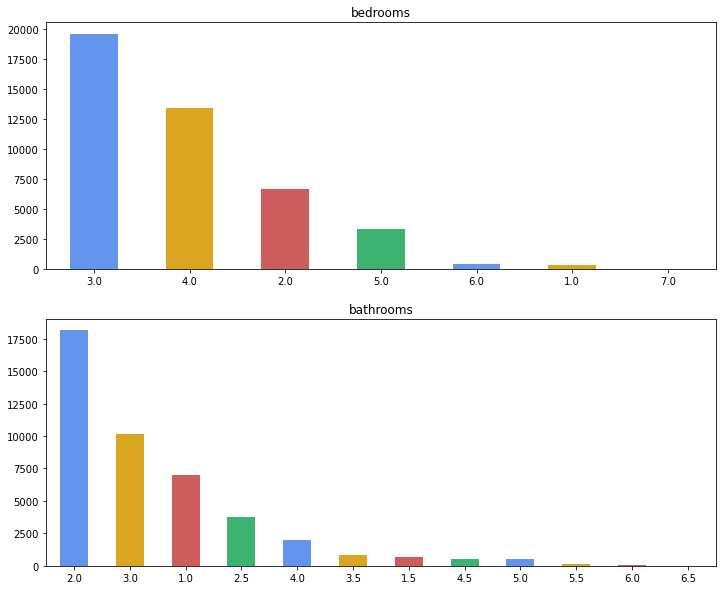

In [8]:
bedbath_counts = ['bedrooms','bathrooms']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (12, 10))
# sets parameters of graphs

for i, item in enumerate(bedbath_counts): 
        ax = df[item].value_counts().plot(kind = 'bar', color = ["cornflowerblue", "goldenrod", "indianred", "mediumseagreen"], ax=axes[i],rot = 0)
    
        ax.set_title(item)
        
# Displays a graphical representation of number of properties with x number of bedrooms and bathrooms

#### Bedroom & Bathroom Counts summary:

Properties having 3 bedrooms and 2 bathrooms is most common, whereas having more than 5 bedrooms and/or bathrooms is least common.

Text(0.5, 1.0, 'Year Built Distribution')

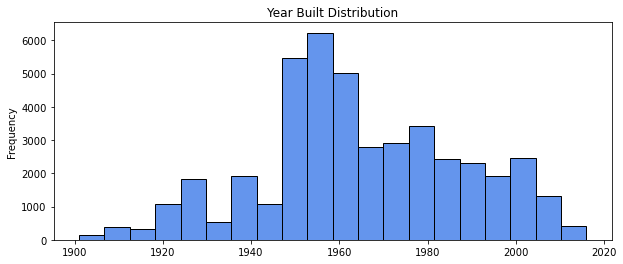

In [9]:
plt.figure(figsize=(10, 4))
# sets size
df.year_built.plot.hist(by= df, bins=20, color = "cornflowerblue", ec= "black")
# additions parameters, data to graph, and binning for readability
plt.title('Year Built Distribution')

#### Year Built Distribution summary:

- Properties built in the 1950s, 1960s, and 1970 are most frequent. 
- A very small percentage of homes were built in the early 1900s

### Exploratory Data Analysis & Statistical Testing

- Create hypotheses regarding drivers of tax assessed property values.
- Split data into 3 subsets for proper statistical analysis and modeling.
- Create hypotheses relating to customer churn.
- Use the train data to explore hypotheses.
- Visualize bivariate and/or multivariate data and assess hypotheses using statistical tests.

### Hypotheses & Exploration Plan:

> Location - Based on basic domain knowledge, I believe location plays a large role in determining tax assessed property value. While the county may be a driver of the target(tax assessed property value), I'd like to dive deeper by narrowing in on location even further. Location determines other unknown attributes (such as proximity to the ocean, school district, etc.) which could greatly impact tax assessed value. Zip codes in the original data are incorrect and do not align with properties in California. Therefore, I will attempt to use latitude and longitude coordinates to explore the notion that location may drive the target variable.

> Square Footage - I hypothesize that home size and potentially lot size are related to tax assessed property value. Logically, I would anticipate larger homes having a higher tax assessed value. I'm not sure whether or not the lot size will be a good predictor of the target as smaller homes may be on a lot of land and vice versa, yet it's possible that lot size and the target are correlated the majority of the time. I will explore these notions through graphical and statistical analysis.

> Rooms Counts - I believe that as the number of bedrooms and bathrooms increases, the tax assessed property value increases. However, there is not much variance in these features and an overwhelming majority of properties have the same number of bedrooms and/or bathrooms. Because of this, I hypothesize that bedroom and bathroom counts will not be the top drivers of the target. Because my basic domain knowledge tells me that room counts likely impact value, I will explore these potential relationships.

> Year Built - My intuition tells me that more modern homes may have enhanced attributes which could mean that year built may be positively correlated to the target. However, my research shows that "historic homes" only need to be 50 years old (or more) and historic homes may be valued higher. I am unsure if (and how many) homes in this dataset are classified as "historic" and whether or not such homes would be considered outliers. I hypothesize that the majority of home ages are correlated with the target as such older homes would have lower tax assessed values. I will explore this notion and keep an eye out for outliers.


### Splitting Data

Splitting data into 3 subsets (train, validate, test) for proper statistical analysis, exploration, modeling, and assessment.
- Train: explore features and relationships to target variable, statistical analysis, build models 
- Validate: evaluate model performance compared to the train dataset, Assess potential overfitting
- Test: run only the chosen top performing to ensure model performs as expected on unseen data before employing

In [10]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting


**Number of Train Records:** 24,606

**Number of Validate Records:** 10,546

**Number of Test Records:** 8,788

### Correlation of Individual Features to Target Variable (Tax Assessed Propert Value)

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Tax Assessed Value'}>

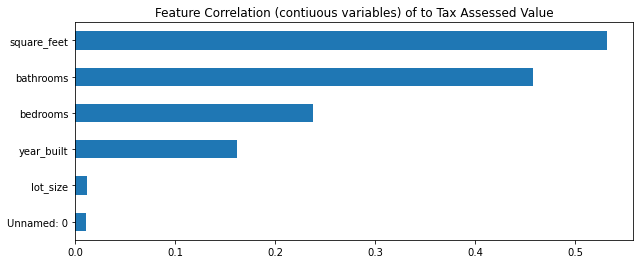

In [11]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Tax Assessed Value")
corr_chart = train.drop(['tax_value', 'fips', 'parcelid', 'longitude', 'latitude'], axis=1).corrwith(train['tax_value']).sort_values().plot.barh()
corr_chart

# graphs the correlation strength of features to the target variable

#### Feature Correlation graph summary:
   - The home size appears to be a strong driver of the target whereas the lot size appears to have essentially no correlation. Therefore, I will move forward with evaluating the relationship of home square footage to tax assessed value. 
   - Bathroom count seems to be more valuable in predicting the tax assessed value than bedroom count. 
   - The year built correlation does not look as strong as the others, but may potentially be useful

#### Square Footage and Tax Assessed Value Exploration

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by County) to Tax Assessed Value')

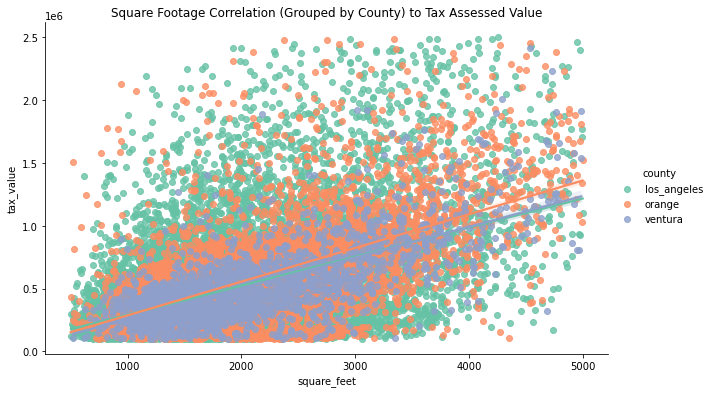

In [12]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='square_feet', y='tax_value', data=train, scatter=True, hue='county', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by County) to Tax Assessed Value")
# plots the correlation of the two variables on a scatter plot with a linear regression line 
# hue is added to show this relationship by each county

#### Square Footage Coorelation (Grouped by County) Graph Summary: 

Interestingly, square footage for properties in Venura County seems to be strongly correlated  with tax assessed value. The other two counties show a weaker correlation so I will run a statistical analysis on each county separately to assess this correlation.

#### Statisical Assessment

- Pearson's R test to determine the potential correlation of square footage and tax assessed value by county

#### Setting Alpha 

- Alpha is set to an industry standard of .05 which will be the threshold in determine statistical significance  

$H_0$: There is no linear correlation between between square footage of ventura homes and tax assessed value

$H_a$ : There is a linear correlation between between square footage of ventura homes and tax assessed value

In [13]:
alpha = .05
# setting alpha to aid in determining statistical significance 
ventura = pd.DataFrame(train[train.county=='ventura'])
# creates a dataframe for all ventura records in the train data
xv = ventura.square_feet
yv = ventura.tax_value
# creates short variable assignments 

corrv, pv = stats.pearsonr(xv, yv)
# creates variables for the r value and the p value respectively 

if pv > alpha:
    print("We fail to reject the null hypothesis")
elif corrv < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

#pearsonr test that returns correlation strength (r value) and p value 
# (must be less than alpha to reject the null hypothesis)

We reject the null hypothesis


$H_0$: There is no linear correlation between between square footage of los angeles homes and tax assessed value

$H_a$ : There is a linear correlation between between square footage of los angeles homes and tax assessed value

In [14]:
la = pd.DataFrame(train[train.county=='los_angeles'])
# creates a dataframe for all LA records in the train data
xl = la.square_feet
yl = la.tax_value
# creates short variable assignments

corrl, pl = stats.pearsonr(xl, yl)
# creates variables for the r value and the p value respectively 

if pl > alpha:
    print("We fail to reject the null hypothesis")
elif corrl < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

#pearsonr test that returns correlation strength (r value) and p value 
#(must be less than alpha to reject the null hypothesis)

We reject the null hypothesis


$H_0$: There is no linear correlation between between square footage of orange co homes and tax assessed value

$H_a$ : There is a linear correlation between between square footage of orange co homes and tax assessed value

In [15]:
orange = pd.DataFrame(train[train.county=='orange'])
# creates a dataframe for all orange co records in the train data
xo = orange.square_feet
yo = orange.tax_value
# creates short variable assignments

corro, po = stats.pearsonr(xo, yo)
# creates variables for the r value and the p value respectively 

if po > alpha:
    print("We fail to reject the null hypothesis")
elif corro < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

#pearsonr test that returns correlation strength (r value) and p value 
#(must be less than alpha to reject the null hypothesis)

We reject the null hypothesis


$H_0$: There is no linear correlation between between square footage of homes in all 3 counties and tax assessed value

$H_a$ : There is a linear correlation between between square footage of homes in all 3 counties and tax assessed value

In [16]:
x = train.square_feet
y = train.tax_value
# creates short variable assignments

corr, p = stats.pearsonr(x, y)
# creates variables for the r value and the p value respectively

if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
    
#pearsonr test that returns correlation strength (r value) and p value 
# (must be less than alpha to reject the null hypothesis)

We reject the null hypothesis


In [17]:
printmd('**Correlation between Ventura Home Size and Tax Assessed Value:** ')
print(f' r = {corrv:.3f}') 
print()
printmd('**Correlation between LA Home Size and Tax Assessed Value:**')
print(f' r = {corrl:.3f}')
print()
printmd('**Correlation between Orange Co Home Size and Tax Assessed Value:** ')
print(f' r = {corro:.3f}')
print()
printmd('**Correlation between All 3 County Home Size and Tax Assessed Value:** ')
print(f' r = {corr:.3f}')

# prints out the r values of the pearsonr tests which shows the strength of the correlation 

**Correlation between Ventura Home Size and Tax Assessed Value:** 

 r = 0.703



**Correlation between LA Home Size and Tax Assessed Value:**

 r = 0.470



**Correlation between Orange Co Home Size and Tax Assessed Value:** 

 r = 0.602



**Correlation between All 3 County Home Size and Tax Assessed Value:** 

 r = 0.532


#### Takeaways from Pearsons r tests on square footage by county: 

The correlation strength of the home size and tax assessed value is definitely different based on county. Since home size is the strongest feature correlation, this is important as it may be beneficial to build separate models for each county to maximize this valuable correlation where possible.

#### Bedrooms, Bathrooms and Tax Assessed Value Exploration

Text(0.5, 1.0, 'Number of Bathrooms and Tax Assessed Value')

<Figure size 1008x360 with 0 Axes>

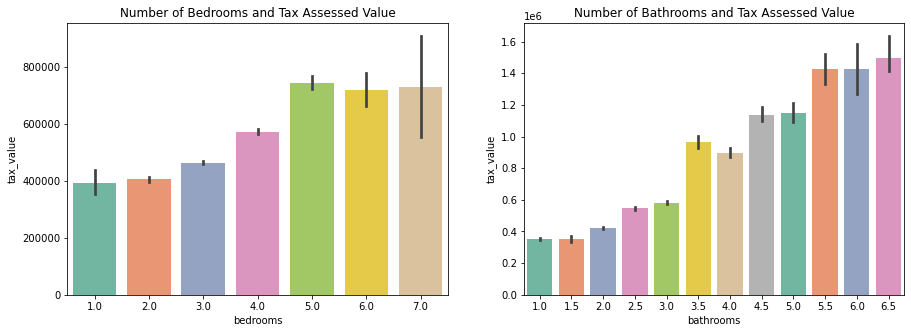

In [18]:
plt.figure(figsize=(14, 5))
sns.set_palette('Set2', 20)
#sets size and color palette for the grapgh

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
#creates subplots that share a y axis

sns.barplot(ax=axes[0], x=train.bedrooms, y=train.tax_value)
axes[0].set_title('Number of Bedrooms and Tax Assessed Value')
#creates first subplot

sns.barplot(ax=axes[1], x=train.bathrooms, y=train.tax_value)
axes[1].set_title('Number of Bathrooms and Tax Assessed Value')
#creates second subplot

#### Takeaways from Visualizations of Room Counts and Target Relationships: 

- Both bedroom count and bathroom count show a linear relationship with tax assessed value.
- However, the majority of homes fall between having 2-4 bedrooms and 1-3 bathrooms (shown previously in univariate exploration)
- The linear relationship of room counts with the majority of homes is much weaker than that of home's having greater than 4 bedrooms and/or bathrooms.
- These relationships may still be valuable for modeling, but will not be the strongest predictors.

#### Year Built and Tax Assessed Value Exploration

Text(0.5, 1.0, 'Year Built Correlation (Grouped by County) to Tax Assessed Value')

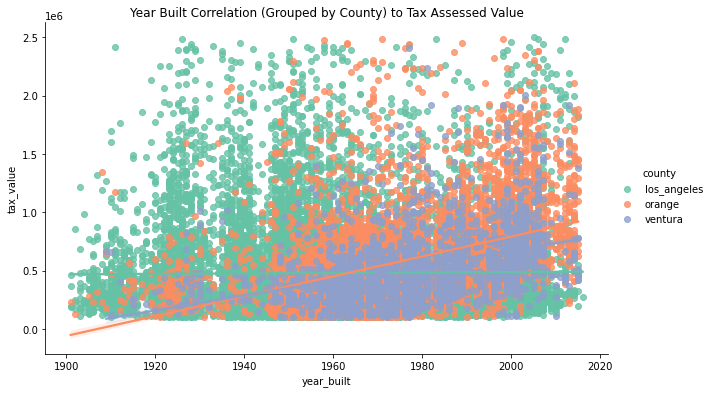

In [19]:
sns.lmplot(x='year_built', y='tax_value', data=train, scatter=True, hue='county', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Year Built Correlation (Grouped by County) to Tax Assessed Value")

# plots the correlation of the two variables on a scatter plot with a linear regression line, 
# hue is added to show this relationship by each county

#### Year Built Correlation (Grouped by County) Graph Summary: 

Similarly to other features, year built for properties in Ventura County have a stronger correlation tax assessed value than the other counties. Year built for properties in Orange county appear to have some linear correlation whereas year built for properties in LA county have a very weak correlation. This further emphasizes the rationale for taking location into account for modeling.

### Exploration Summary

- Location - This was not included in this exploration as I was unsuccessful at binning locations from latitude and longitude that showed any significant correlation to the target. For current modeling, I will leave this feature alone.

- Square Footage - My hypothesis regarding this positive correlation to the target is correct and this feature seems to be the most valuable in predicting the target. 

- Rooms Counts - My hypothesis regarding this correlation to the target is correct. Bathroom counts are somewhat highly correlated to the target whereas bedroom count correlation is a bit weaker.

- Year Built - There is a weak correlation between year built and the target. The correlation strength for year built is dependent on county.

### Pre-Modeling
- Select features to use in the modeling process
- Create X (features) and y (target variable) dataframes for the 3 data subsets: train, validate, test
- Scale data with different units of measurements to have more accurate(weighted) influnence in modeling

##### The following features are deemed valuable for predicting the target variable based on exploration :

- Square Feet
- Bathrooms
- Bedrooms
- Year Build

###### Note: I did attempt to bin locations using property latitude and logitude with KMeans clustering, however I did not successfully create a location feature that has enough consistency with target variable correlation to be employed in modeling at this time.

In [20]:
X_train = train.drop(columns=['lot_size', 'parcelid', 'tax_value', 'fips', 'latitude', 'longitude', 'county'])
# creates dataframe that drops all column except the selected features for modeling
y_train = train[['tax_value']]
# creates dataframe of target variable (y) only

X_validate = validate.drop(columns=['lot_size', 'parcelid', 'tax_value', 'fips','latitude', 'longitude', 'county'])
y_validate = validate[['tax_value']]
# repeat above for validate set

X_test = test.drop(columns=['lot_size', 'parcelid', 'tax_value', 'fips', 'latitude', 'longitude', 'county'])
y_test = test[['tax_value']]
# repeat above for test set

#### Scaling Data Using Min Max Scaler

Rationale for scaling: Because the four continuous numerical features have vastly different ranges with different units of measurement, this process will change the range for all feature values to 0-1. For example, the highest square footage (near 5,000) value will be 1 whereas the highest bedroom count (~7) will also be 1. This equalizes values so importance is not wrongfully granted to features with a higher numeric range.

Note: The target variable is not included in scaling as it is essential to assess the actual value of the target through modeling

In [21]:
scaler = sklearn.preprocessing.MinMaxScaler()
# employs the min max scaler
scaler.fit(X_train[['bedrooms', 'bathrooms', 'square_feet', 'year_built']])
# inserts the 4 selected features into the scaler

X_train[['scaledbed', 'scaledbath', 'scaledsize', 'scaledyear']] = data=scaler.transform(X_train[['bedrooms', 'bathrooms', 'square_feet', 'year_built']])
X_validate[['scaledbed', 'scaledbath', 'scaledsize', 'scaledyear']] = data=scaler.transform(X_validate[['bedrooms', 'bathrooms', 'square_feet', 'year_built']])
X_test[['scaledbed', 'scaledbath', 'scaledsize', 'scaledyear']] = data=scaler.transform(X_test[['bedrooms', 'bathrooms', 'square_feet', 'year_built']]) 
# tranforms the features' values with the new equal scale and assigns new column names for the scaled version of the data

In [22]:
X_train = X_train.drop(columns = ['bedrooms', 'bathrooms', 'year_built', 'square_feet'])
X_validate = X_validate.drop(columns = ['bedrooms', 'bathrooms', 'year_built','square_feet'])
X_test = X_test.drop(columns = ['bedrooms', 'bathrooms', 'year_built', 'square_feet'])
# drops the original feature names so only the scaled data is left in the X dataframes to use in modeling

### Modeling

- Use common regression algorithms (supervised machine learning technique) to predict the continuous target variable (tax assessed property value)

#### Models to consider: 
- Ordinary Least Squares: Standard linear regression model
- LARS: evokes feature selection and noise reduction to improve performance (y should be evenly distributed)
- Generalized Linear Model(TweedieRegressor): Most flexible model that allows for different distributions (controlled in parameters)
- Polynomial Regression: Similar to linear regression, but transforms polynomial features by an expected degree (represented as a slight curve graphically)

I will attempt modeling with these 4 model types on train data and assess the performance compared to baseline prediction and validate set.

#### Establishing Baseline

- Root Mean Square Error (RMSE) is used to measure the error of the model (higher the number, larger the error)

- The baseline RMSE is established by commuting the RMSE of the target variable. 

In [23]:
y_train['pred_mean'] = y_train.tax_value.mean()
y_validate['pred_mean'] = y_validate.tax_value.mean()
# calculates mean prior to computing rmse

rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_mean)**(1/2)
# computes baseline RMSE for train and validate sets (square root of MSE)

print("Baseline RMSE\nTrain/In-Sample: ", round(rmse_train, 2)), 
print("Baseline RMSE\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

Baseline RMSE
Train/In-Sample:  375448.45
Baseline RMSE
Validate/Out-of-Sample:  374243.79


#### Baseline RMSE is ~ 375,000

- This means that without modeling and just computing the RMSE using the target variable mean, tax assessed value can be predicted with ~ $375,000 error
- For the following models to be valuable, their RMSE must be lower than the baseline RMSE

#### Ordinary Least Squares: Linear Regression Model

In [24]:
lm = LinearRegression(normalize=True)
# create the model

lm.fit(X_train, y_train.tax_value)
# fit the model to scaled training data

y_train['value_predict_lm'] = lm.predict(X_train)
# computes model predictions
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_predict_lm)**(1/2)
# computes model rmse

y_validate['value_predict_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_predict_lm)**(1/2)
# comutes predictions and rmse with validate data

printmd("**OLS Linear Regression Performance**")
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 2))
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

**OLS Linear Regression Performance**

---------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  310199.89
---------------------------------------
RMSE for OLS using LinearRegression
Validation/Out-of-Sample:  309803.52


##### OLS Linear Regression Performance Summary:

This model performs well as there is essentially no difference in the RMSE of the train and validate date. This means that overfitting is not an issue. Also, this model is clearly performing better than the baseline. 

#### Least-Angle Regression (LARS) Model

In [25]:
lars = LassoLars(alpha=1.0)
# creates the model

lars.fit(X_train, y_train.tax_value)
# fit the model to scaled training data

y_train['pred_lars'] = lars.predict(X_train)
# computes model predictions
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(1/2)
# computes model rmse

y_validate['pred_lars'] = lars.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(1/2)
# comutes predictions and rmse with validate data

printmd("**LARS Performance**")
print("---------------------------------------")
print("RMSE for Lars\nTraining/In-Sample: ", round(rmse_train, 2))
print("---------------------------------------")
print("RMSE for Lars\nOut-of-Sample: ", round(rmse_validate, 2))

**LARS Performance**

---------------------------------------
RMSE for Lars
Training/In-Sample:  310200.29
---------------------------------------
RMSE for Lars
Out-of-Sample:  309807.78


##### LARS Performance Summary:

This model performs almost identically to the OLS model. Overfitting is not an issue here and this model is performing better than the baseline also.

#### Generalized Linear Model (TweedieRegressor)

In [26]:
glm = TweedieRegressor(power= 1, alpha=5)
# creates the model

glm.fit(X_train, y_train.tax_value)
# fit the model to scaled training data

y_train['pred_value_glm'] = glm.predict(X_train)
# computes model predictions
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_value_glm)**(1/2)
# computes model rmse

y_validate['pred_value_glm'] = glm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_value_glm)**(1/2)
# comutes predictions and rmse with validate data

printmd("**Generalized Linear Model Performance**")
print("---------------------------------------")
print("RMSE for GLM /In-Sample: ", round(rmse_train, 2)), 
print("---------------------------------------")
print("RMSE for GLM \nValidation/Out-of-Sample: ", round(rmse_validate, 2))

**Generalized Linear Model Performance**

---------------------------------------
RMSE for GLM /In-Sample:  375448.45
---------------------------------------
RMSE for GLM 
Validation/Out-of-Sample:  374243.8


##### GLM Performance Summary :

This models' performance closely aligns with the previous 2 models. Overfitting is not an issue here and this model is performing better than the baseline.

#### Polynomial Regression Model

In [27]:
pf = PolynomialFeatures(degree=3)
# creates polynomial features to use in model with degree of 3

X_train_degree3 = pf.fit_transform(X_train)
# fit and transform X_train_scaled

X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)
# transform X_validate_scaled & X_test_scaled

In [28]:
lm3 = LinearRegression(normalize=True)
# creates linear regression model prior to fitting with new polynomial features

lm3.fit(X_train_degree3, y_train.tax_value)
# fit and transform polynomial features and target

y_train['value_pred_lm3'] = lm3.predict(X_train_degree3)
# predictions calculated on train

rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm3)**(1/2)
# computes rmse with train

y_validate['value_pred_lm3'] = lm3.predict(X_validate_degree3)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm3)**(1/2)
# computes predictions/rmse with validate

printmd("**Polynomial Regression Model Performance**")
print("---------------------------------------")
print("RMSE for Polynomial Model \nTraining/In-Sample: ", round(rmse_train, 2)),
print("---------------------------------------")
print("RMSE for Polynomial Model, \nValidation/Out-of-Sample: ", round(rmse_validate, 2))

**Polynomial Regression Model Performance**

---------------------------------------
RMSE for Polynomial Model 
Training/In-Sample:  304291.28
---------------------------------------
RMSE for Polynomial Model, 
Validation/Out-of-Sample:  305278.9


##### Polynomial Regression Performance Summary :

Based on RMSE of train and validate data, this model is superior to the other regression models. Overfitting is not an issue, this model performs well above baseline and the RMSE is the best out of the 4 models.

### Model Selection & Employing on Test Data:

- The polynomial regression model (degree=3), is the best performing model and should be employed as the improved target predictor. 
- I will run this model once more on the test data to assure this model performs well on unseen data.

In [29]:
y_test['value_predict_lm3'] = lm3.predict(X_test_degree3)
rmse_test = mean_squared_error(y_test.tax_value, y_test.value_predict_lm3)**(1/2)

printmd("**Polynomial Regression Model Performance on Test Data**")
print("---------------------------------------")
print("RMSE : Test Data \nTesting/Out-of-Sample: ", round(rmse_test, 2))

**Polynomial Regression Model Performance on Test Data**

---------------------------------------
RMSE : Test Data 
Testing/Out-of-Sample:  300823.18


#### Model Selection Summary: 

Fortuitously, the polynomial regression model performs even better on the test data. With all 3 data sets performing similarly and approximately 22% better than baseline predictions, I can confidently recommend the implementation of this model in practice at Zillow.

### Conclusion

- I successfully created a machine learning regression model that improves predicted property tax assessed values of single family homes in Ventura, Orange, and Los Angeles counties with a 22% improvement from baseline/previous predictions.

- Key Drivers of property value for single family properties are:
     > - property size (square footage)
     > - property's year built
     > - bedroom count
     > - bathroom count
     
- My polynomial regression model has been tailored with ideal parameters (degree=3) and has performed consistently well on trained data and unseen data.

- This model is ready for utilization and I strongly recommend Zillow to employ this model to predict tax assessed property value as soon as possible.

#### Next Steps for Improving Predictions

- Location Data- I would like to continue to explore how I can implement location data into a machine learning algorithm to increase prediction accuracy.

- Tax Assessor Interview - I would like to contact tax assessors for these areas and try to gain insight from them on exactly how tax values are assessed. 
     
- Explore additional home features, renovations, etc. that may drive tax assessed value
- Continue to evaluate and improve current model as new data becomes available